In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from os import makedirs, path, listdir, remove
import matplotlib.pyplot as plt

In [2]:
folder = "/home/users/mwlw3/ADMS-Urban/2019_CERC_subset/"
files = [path.join(folder, file) for file in listdir(folder)]

In [3]:
print(files)

['/home/users/mwlw3/ADMS-Urban/2019_CERC_subset/20210331_2019_HighResGrid_Corrected.00034.nc', '/home/users/mwlw3/ADMS-Urban/2019_CERC_subset/20210331_2019_HighResGrid_Corrected.00142.nc', '/home/users/mwlw3/ADMS-Urban/2019_CERC_subset/20210331_2019_HighResGrid_Corrected.00151.nc', '/home/users/mwlw3/ADMS-Urban/2019_CERC_subset/20210331_2019_HighResGrid_Corrected.00280.nc']


In [4]:
ds = xr.open_dataset(files[0])

In [5]:
ds

<xarray.Dataset>
Dimensions:                               (nPoints_XY: 7857, nPoints_XYZ: 7857, nMetLines: 8760, nGroups: 1, nDatasets: 6, OutputOptionsUsed: 3, NumberOfTypesOfOutputPoint: 5)
Dimensions without coordinates: nPoints_XY, nPoints_XYZ, nMetLines, nGroups, nDatasets, OutputOptionsUsed, NumberOfTypesOfOutputPoint
Data variables: (12/24)
    PointX_XY                             (nPoints_XY) float32 ...
    PointY_XY                             (nPoints_XY) float32 ...
    PointName_XY                          (nPoints_XY) |S44 ...
    PointX_XYZ                            (nPoints_XYZ) float32 ...
    PointY_XYZ                            (nPoints_XYZ) float32 ...
    PointZ_XYZ                            (nPoints_XYZ) float32 ...
    ...                                    ...
    Dataset5                              (nMetLines, nGroups, nPoints_XYZ) float32 ...
    Dataset6                              (nMetLines, nGroups, nPoints_XYZ) float32 ...
    Output_Options_Description            (OutputOptionsUsed) |S14 ...
    Output_Options_Used                   (OutputOptionsUsed) int32 ...
    Output_Points_Type                    (NumberOfTypesOfOutputPoint) |S16 ...
    Number_Of_Output_Points_Of_Each_Type  (NumberOfTypesOfOutputPoint) int32 ...
Attributes: (12/14)
    File_Version:               2.0
    File_Type:                  Comprehensive output file
    Site_Name:                  London Baseline 2019
    Project_Name:               Breathe London
    Coordinate_System:          OSGB 1936 British National Grid (epsg:27700)
    EPSG:                       27700
    ...                         ...
    Model_Name:                 ADMS-Urban
    Model_Version:              5.0.0.1
    Model_Build_Number:         5129
    Model_Release_Date:         January 2020
    Date_Created:               1/4/2021
    Time_Created:               15:44:59

There is a Dataset for each pollutant species:

In [6]:
NO2_da = ds.Dataset2

Each pollutant dataset has a time dimension, represented by met lines, and a space dimension, represented by XYZ point number:

In [7]:
for dim in zip(NO2_da.dims, NO2_da.values.shape):
    print(dim)

('nMetLines', 8760)
('nGroups', 1)
('nPoints_XYZ', 7857)


To identify the timestamp from the met lines, the `Met_Line` dataset contains timestamps encoded as YYYY_DDD_HH, with days numbered from 1 to 365.

To identify the spatial coordinates (OSGB (British National Grid)), the `PointX_XYZ`, `PointY_XYZ`, and `PointZ_XYZ` datasets contain the X, Y, and Z coordinates respectively.

The DataArray can be indexed like a `numpy` array e.g. to obtain only the concentrations through time at one spatial point:

In [8]:
NO2_da[:,0,0].values

array([11.002524,  5.578443,  6.289382, ..., 28.578184, 39.43798 ,
       39.793713], dtype=float32)

The DataArray can also be averaged over a dimension like a `numpy` array e.g. spatially averaged timeseries:

In [9]:
NO2_da.mean(axis=2).squeeze().values

array([14.882189,  6.676511,  7.585675, ..., 32.535908, 44.098454,
       44.067215], dtype=float32)

In [10]:
def metline_to_datetime(i):
    numbers = str(i).replace("b", "").replace("'", "").split("_")
    return(np.datetime64(f"{numbers[0]}")+ np.timedelta64(int(numbers[1])-1, "D") + np.timedelta64(int(numbers[2]), "h"))

In [11]:
datetime_index = []
for i in ds.Met_Line.values:
    datetime_index.append(metline_to_datetime(i))

In [12]:
df = pd.DataFrame(NO2_da.mean(axis=2).squeeze().values, index=datetime_index, columns=["spatial_mean_NO2"])
df = df.replace(-999, np.nan)

In [13]:
def plot_timeseries(dataframe, columns, title, units, figure_size=(8,4)):
    plt.figure(figsize=figure_size, dpi=300)
    for column in columns:
        dataframe[column].plot()
    plt.legend()
    plt.ylabel(units)
    plt.suptitle(title)
    plt.show()

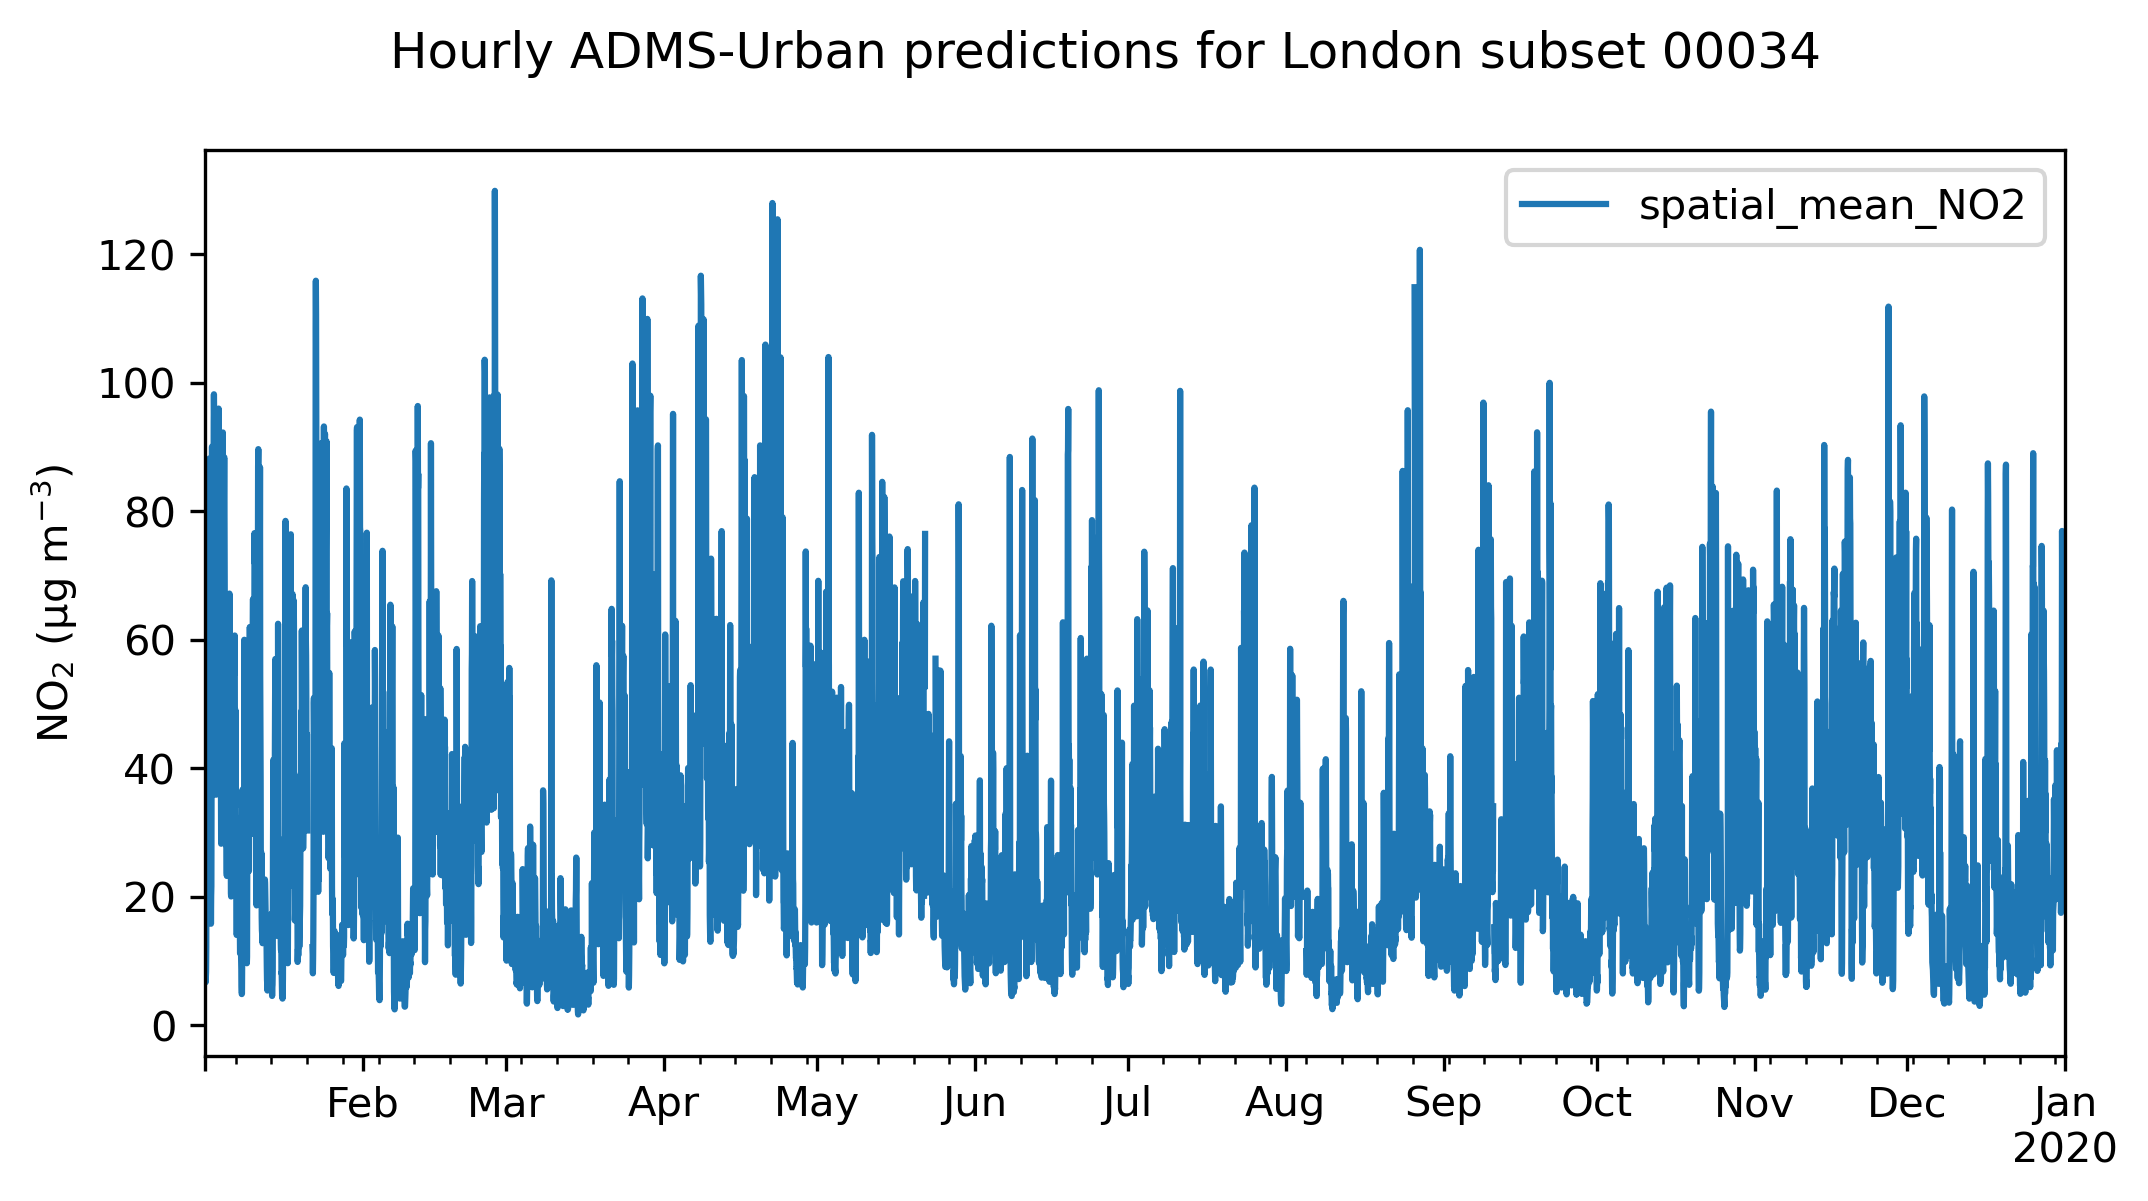

In [14]:
plot_timeseries(df, ["spatial_mean_NO2"], "Hourly ADMS-Urban predictions for London subset 00034", "NO$_2$ (µg m$^{-3}$)")